# The Moran Process with the Axelrod library

The [Moran process](https://en.wikipedia.org/wiki/Moran_process) is a common population model of natural selection. With the wealth of strategies in the [axelrod library](https://github.com/Axelrod-Python), implementing a Moran process is simple.

The basic idea of the model is that we have a population of $N$ individuals. The population size is fixed throughout. Each round every player interacts with every other player, in this case the default game in the axelrod library, the [prisoner's dilemma](https://en.wikipedia.org/wiki/Prisoner's_dilemma).

After the scores are summed for each player, we choose one to reproduce proportionally to its score ([fitness proportionate selection](https://en.wikipedia.org/wiki/Fitness_proportionate_selection)). We also choose one player to replace, at random uniformly. The process continues until the population consists of a single type ([fixation](https://en.wikipedia.org/wiki/Fixation_%28population_genetics%29)).

In [1]:
# Python 3
%matplotlib inline

from collections import defaultdict, Counter
import itertools
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import axelrod as axl

plt.rcParams['figure.figsize'] = (10, 10)
# sns.set_context('paper', font_scale=1.5, size=8)

In [2]:
def fitness_proportionate_selection(scores):
    csums = np.cumsum(scores)
    total = csums[-1]
    r = random.random() * total    

    for i, x in enumerate(csums):
        if x >= r:
            return i

def print_dict_sorted(d):
    items = [(v, k) for (k, v) in d.items()]
    for v, k in sorted(items):
        print("{v}: {k}".format(v=v, k=k))

In [3]:
# Moran Process

def moran_process(players, turns=10, verbose=True):
    """The Moran process.
    
    Parameters
    ----------
    players: sequence
        a collection of Axelrod players
    turns: int, 10
        the number of turns in each interaction
    verbose: bool, True
        report progress as rounds proceed
    
    Returns
    -------
    populations, list[dict]
        the populations in each round, indexed by player name
    scores, list[dict]
        the scores for each player each round, indexed by name
    """
    populations = []
    round_scores = []
    N = len(players)
    for round_number in itertools.count(1):
        player_names = [player.name for player in players]
        counter = Counter(player_names)
        populations.append(counter)

        # Exit condition: Population consists of a single player type
        if len(set(player_names)) == 1:
            break
        # Otherwise report progress
        if verbose:
            print("\nRound:", round_number)
            print_dict_sorted(counter)

        # Everyone plays everyone else
        scores = [0] * N
        for i in range(len(players)):
            for j in range(i + 1, len(players)):
                player1 = players[1]
                player2 = players[2]
                player1.reset()
                player2.reset()
                match = axl.Match((player1, player2), turns)
                results = match.play()
                match_scores = np.sum(match.scores(), axis=0) / float(turns)
                scores[i] += match_scores[0]
                scores[j] += match_scores[1]
        score_dict = defaultdict(float, dict(zip(player_names, scores)))
        for k, v in counter.items():
            score_dict[k] /= (float(v) * turns)
        round_scores.append(score_dict)
        # Fitness proportionate selection
        j = fitness_proportionate_selection(scores)
        # Randomly remove a strategy
        i = random.randrange(0, N)
        # Replace player i with player j
        players[i] = players[j].clone()
    if verbose:
        print("\n", players[0].name, "is the winner!")
    return populations, round_scores

In [4]:
# Run the process

N = 10
players = []
for _ in range(N):
    player = random.choice(axl.basic_strategies)
    players.append(player())

populations, scores = moran_process(players, verbose=False)
winner_name = list(populations[-1].keys())[0]
rounds = len(populations)
print(winner_name, "is the winner after {rounds} rounds!!".format(rounds=rounds))

Tit For Tat is the winner after 147 rounds!!


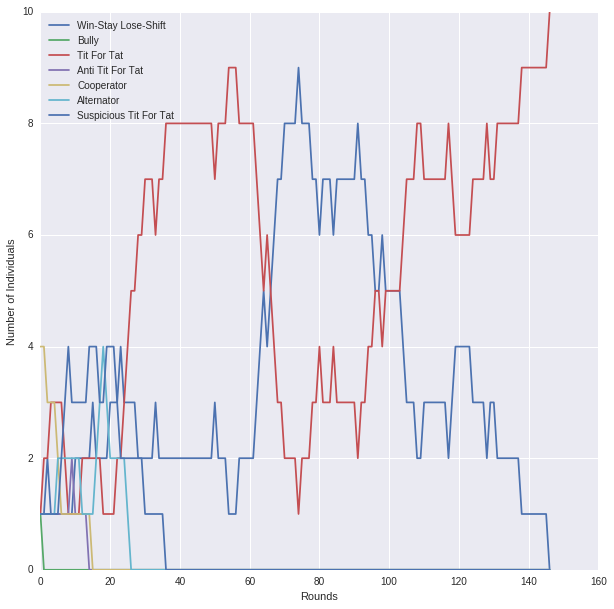

In [5]:
# Plot the results, first the Populations

player_names = populations[0].keys()
for name in player_names:
    values = [counter[name] for counter in populations]
    domain = range(len(values))
    plt.plot(domain, values, label=name)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="upper left")
plt.xlabel("Rounds")
plt.ylabel("Number of Individuals")
plt.show()

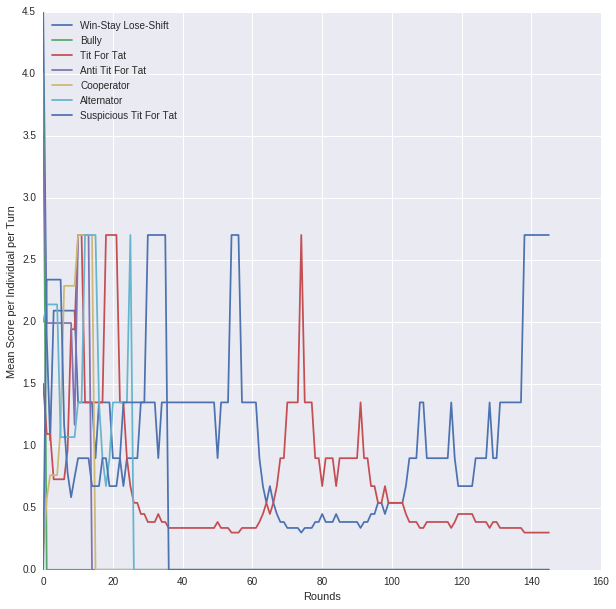

In [6]:
# Plot the results, second the scores

player_names = scores[0].keys()
for name in player_names:
    values = [counter[name] for counter in scores]
    domain = range(len(values))
    plt.plot(domain, values, label=name)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="upper left")
plt.xlabel("Rounds")
plt.ylabel("Mean Score per Individual per Turn")
plt.show()